In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e9/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s3e9/test.csv')
original = pd.read_csv('/kaggle/input/predict-concrete-strength/ConcreteStrengthData.csv')

In [3]:
train_df.drop('id',axis=1,inplace=True)
original['CementComponent'] = original['CementComponent ']
original.drop('CementComponent ',axis=1,inplace=True)
combined_df = pd.concat([train_df.copy(),original.copy()],ignore_index=True)

Epoch 1/100
129/129 [==============================] - 3s 13ms/step - loss: 575.1736 - mae: 18.7225 - mse: 575.1736 - val_loss: 276.6036 - val_mae: 13.0692 - val_mse: 276.6036
Epoch 2/100
129/129 [==============================] - 1s 9ms/step - loss: 250.3920 - mae: 12.4815 - mse: 250.3920 - val_loss: 239.8956 - val_mae: 12.2168 - val_mse: 239.8956
Epoch 3/100
129/129 [==============================] - 1s 9ms/step - loss: 226.2328 - mae: 11.8397 - mse: 226.2328 - val_loss: 213.5389 - val_mae: 11.4497 - val_mse: 213.5389
Epoch 4/100
129/129 [==============================] - 1s 9ms/step - loss: 201.1357 - mae: 11.0399 - mse: 201.1357 - val_loss: 183.1328 - val_mae: 10.5225 - val_mse: 183.1328
Epoch 5/100
129/129 [==============================] - 1s 9ms/step - loss: 171.7331 - mae: 10.1108 - mse: 171.7331 - val_loss: 159.7033 - val_mae: 9.6751 - val_mse: 159.7033
Epoch 6/100
129/129 [==============================] - 0s 3ms/step - loss: 156.3403 - mae: 9.5777 - mse: 156.3403 - val_loss:

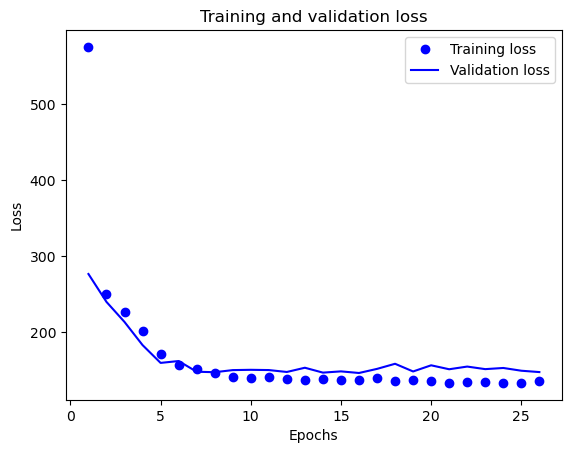

 43/113 [==========>...................] - ETA: 0s 

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


113/113 [==============================] - 0s 1ms/step


In [4]:
X = combined_df.iloc[:, :-1].values
y = combined_df.iloc[:, -1].values

# Scale the data using StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[X.shape[1]]),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='mse', metrics=['mae', 'mse'])

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='nn_v1', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100,
                    callbacks = [early_stopping_callback,checkpoint_callback],
                    batch_size=32, validation_split=0.2)

# Plot the train/validation loss chart
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

tmp = test_df.drop('id',axis=1)
tmp = scaler.transform(tmp)
nn_pred = model.predict(tmp)
nn_pred_flat = nn_pred.reshape(-1)
nn_pred_flat

nn_submission_data = {'id': test_df.id, 'Strength': nn_pred_flat}
nn_submission_df = pd.DataFrame(nn_submission_data)
nn_submission_df.to_csv('nn_submission.csv',index=False)


https://www.kaggle.com/code/vaidyaprasad84/ps3-e9-feature-engineering

In [5]:
def feature_engineer(df):
    df['Water_Cement'] = df['WaterComponent']/df['CementComponent']
    df['Coarse_Fine'] = df['CoarseAggregateComponent']/df['FineAggregateComponent']
    df['Aggregate'] = df['CoarseAggregateComponent'] + df['FineAggregateComponent']
    df['Aggregate_Cement'] = df['Aggregate']/df['CementComponent']
    df['Slag_Cement'] = df['BlastFurnaceSlag']/df['CementComponent']
    df['Ash_Cement'] = df['FlyAshComponent']/df['CementComponent']
    df['Plastic_Cement'] = df['SuperplasticizerComponent']/df['CementComponent']
    df['Age_Water'] = df['AgeInDays']/df['WaterComponent']

In [6]:
feature_engineer(combined_df)

In [7]:
combined_df.head()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,Water_Cement,Coarse_Fine,Aggregate,Aggregate_Cement,Slag_Cement,Ash_Cement,Plastic_Cement,Age_Water
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38,0.354286,1.835237,1738.0,3.310476,0.000000,0.0,0.000000,0.016129
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52,1.335664,1.503888,1610.0,11.258741,1.181818,1.0,0.055944,0.146597
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96,0.642561,1.351691,1870.3,6.471626,0.466090,0.0,0.000000,0.150781
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05,0.750000,1.391045,1602.0,5.269737,0.250000,0.0,0.000000,1.600877
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19,1.222930,1.197389,1716.6,10.933758,1.503185,0.0,0.000000,0.468750


Epoch 1/100
145/145 [==============================] - 2s 10ms/step - loss: 550.8116 - mae: 18.2943 - mse: 550.8116 - val_loss: 272.4917 - val_mae: 12.9596 - val_mse: 272.4917
Epoch 2/100
145/145 [==============================] - 1s 8ms/step - loss: 242.7344 - mae: 12.2861 - mse: 242.7344 - val_loss: 235.7003 - val_mae: 11.9960 - val_mse: 235.7003
Epoch 3/100
145/145 [==============================] - 1s 8ms/step - loss: 220.0215 - mae: 11.6725 - mse: 220.0215 - val_loss: 206.5004 - val_mae: 11.3226 - val_mse: 206.5004
Epoch 4/100
145/145 [==============================] - 2s 11ms/step - loss: 182.9583 - mae: 10.5195 - mse: 182.9583 - val_loss: 164.0536 - val_mae: 9.8817 - val_mse: 164.0536
Epoch 5/100
145/145 [==============================] - 1s 9ms/step - loss: 158.0763 - mae: 9.6692 - mse: 158.0763 - val_loss: 151.8664 - val_mae: 9.4733 - val_mse: 151.8664
Epoch 6/100
145/145 [==============================] - 0s 2ms/step - loss: 149.7153 - mae: 9.3815 - mse: 149.7153 - val_loss: 

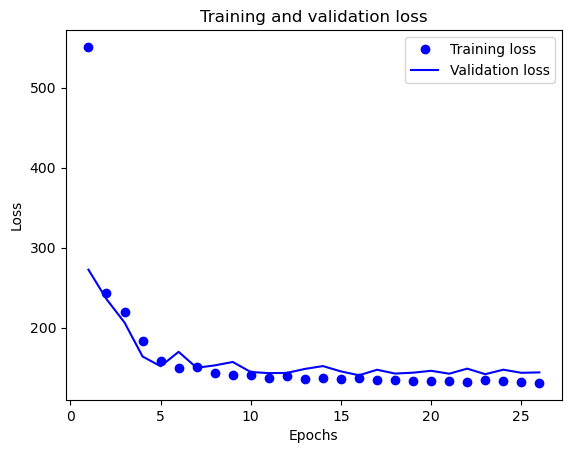

In [8]:
X = combined_df.drop('Strength',axis=1).values
y = combined_df.loc[:,'Strength'].values

# Scale the data using StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Define the model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[X.shape[1]]),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='mse', metrics=['mae', 'mse'])

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='nn_v1', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100,
                    callbacks = [early_stopping_callback,checkpoint_callback],
                    batch_size=32, validation_split=0.2)

# Plot the train/validation loss chart
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
tmp = test_df.drop('id',axis=1)
feature_engineer(tmp)
tmp = scaler.transform(tmp)
nn_pred = model.predict(tmp)
nn_pred_flat = nn_pred.reshape(-1)
nn_pred_flat

nn_submission_data = {'id': test_df.id, 'Strength': nn_pred_flat}
nn_submission_df = pd.DataFrame(nn_submission_data)
nn_submission_df.to_csv('submission.csv',index=False)

 44/113 [==========>...................] - ETA: 0s

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


113/113 [==============================] - 0s 1ms/step


In [10]:
nn_submission_df

,id,Strength
0,5407,51.892376
1,5408,16.919874
2,5409,34.433327
3,5410,46.371868
4,5411,29.865444
...,...,...
3600,9007,32.142109
3601,9008,33.734116
3602,9009,39.567989
3603,9010,40.676945
